## Устанваливаем все библиотеки нужные для FinRL и для работы в Google Colab

In [ ]:
!pip install wrds
!pip install swig
!pip install -q condacolab
import condacolab
condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

✨🍰✨ Everything looks OK!
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-4faanr6u
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-4faanr6u
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit 9f47d57754803e8ecc6e0cbd69b771bd8adc4e90
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-0l7018d_/elegantrl_2d2c2987d0ee4ca89758f2aaf8c1584d
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-0l7018d_/elegantrl_2d2c2987d0ee4ca89758f2aaf8c1584d
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit e97552ba6d1d5df503d7a71dc92a33492590831e
  Preparing metadata (setup.py) ... done


Подключаем Google Drive, чтобы сравнить датасет из статьи и через YahoFinance

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Подключаем нужные библиотеки из FINRL который мы уже загрузили и классические библиотек Python для работы

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from stable_baselines3.common.logger import configure

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [ ]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

## Подстриваемся под данные DJI не на момент 2021 года, а как в датасете в статье

In [ ]:
print(DOW_30_TICKER)
DOW_30_TICKER[0]='DD'
DOW_30_TICKER[1]='AXP'
DOW_30_TICKER[9]='XOM'
DOW_30_TICKER[23]='RTX'
DOW_30_TICKER[29]='PFE'

['DD', 'AXP', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'XOM', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'RTX', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'PFE']


## Задаем тренировочные и тестовые данные согласно статье

In [ ]:
 TRAIN_START_DATE = '2009-01-01'
 TRAIN_END_DATE = '2014-12-31'
 TEST_START_DATE = '2016-01-04'
 TEST_END_DATE = '2020-08-05'


dannie = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of DataFrame:  (87510, 8)


In [ ]:
TEST_START_DATE

'2016-01-04'

## Первые 30 данных применяя библиотеку Yahoo Finance

In [ ]:
dannie.head(30)

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.743890,746015200,AAPL,4
1,2009-01-02,18.570000,19.520000,18.400000,15.144917,10955700,AXP,4
2,2009-01-02,42.799999,45.560001,42.779999,33.941097,7010200,BA,4
3,2009-01-02,44.910000,46.980000,44.709999,30.950020,7117200,CAT,4
4,2009-01-02,16.410000,17.000000,16.250000,11.595376,40980600,CSCO,4
5,2009-01-02,74.230003,77.300003,73.580002,41.939831,13695900,CVX,4
6,2009-01-02,21.605234,22.060680,20.993229,14.492131,13251037,DD,4
7,2009-01-02,22.760000,24.030001,22.500000,20.530584,9796600,DIS,4
8,2009-01-02,84.019997,87.620003,82.190002,67.129234,14088500,GS,4
9,2009-01-02,23.070000,24.190001,22.959999,16.550156,14902500,HD,4


### Конец данных:

In [ ]:
dannie.tail()

,date,open,high,low,close,volume,tic,day
87505,2020-08-04,191.130005,192.940002,190.080002,187.270813,8204000,V,1
87506,2020-08-04,57.200001,58.139999,57.180000,47.611710,11601000,VZ,1
87507,2020-08-04,40.840000,41.070000,40.480000,33.959461,5778500,WBA,1
87508,2020-08-04,43.216667,43.903332,42.980000,41.421295,18219600,WMT,1
87509,2020-08-04,42.340000,43.599998,42.240002,36.136169,17724000,XOM,1


## Размерность

In [ ]:
dannie.shape

(87510, 8)

## Рассматриваем данные из статьи Hongyang

In [ ]:
df0=pd.read_csv('/content/drive/My Drive/dataset/done_data.csv')
df0.iloc[1:30,1:8]

,datadate,tic,adjcp,open,high,low,volume
1,20090102,AXP,19.330000,18.570000,19.52000,18.400000,10955620.0
2,20090102,BA,45.250000,42.800000,45.56000,42.780000,7010171.0
3,20090102,CAT,46.910000,44.910000,46.98000,44.710000,7116726.0
4,20090102,CSCO,16.960000,16.410000,17.00000,16.250000,40977480.0
5,20090102,CVX,76.520000,74.230000,77.30000,73.580000,13695840.0
6,20090102,DD,46.234623,45.544554,46.50465,44.254425,18859390.0
7,20090102,DIS,23.920000,22.760000,24.03000,22.500000,9796596.0
8,20090102,GS,86.760000,84.020000,87.62000,82.190000,14087610.0
9,20090102,HD,24.130000,23.070000,24.19000,22.960000,14902490.0
10,20090102,IBM,87.370000,83.890000,87.59000,83.890000,7557927.0


## Это в точности, как данные в статье (кроме Apple)

In [ ]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.743890,746015200,AAPL,4
1,2009-01-02,18.570000,19.520000,18.400000,15.144917,10955700,AXP,4
2,2009-01-02,42.799999,45.560001,42.779999,33.941097,7010200,BA,4
3,2009-01-02,44.910000,46.980000,44.709999,30.950020,7117200,CAT,4
4,2009-01-02,16.410000,17.000000,16.250000,11.595376,40980600,CSCO,4


## Рассматриваем сколько компаний в индексе

In [ ]:
len(dannie.tic.unique())

30

In [ ]:
dannie.tic.value_counts()

tic
AAPL    2917
AXP     2917
WMT     2917
WBA     2917
VZ      2917
V       2917
UNH     2917
TRV     2917
RTX     2917
PG      2917
PFE     2917
NKE     2917
MSFT    2917
MRK     2917
MMM     2917
MCD     2917
KO      2917
JPM     2917
JNJ     2917
INTC    2917
IBM     2917
HD      2917
GS      2917
DIS     2917
DD      2917
CVX     2917
CSCO    2917
CAT     2917
BA      2917
XOM     2917
Name: count, dtype: int64

## Добавляем технические индекаторы

In [ ]:
INDICATORS = ['macd','boll_ub','boll_lb','rsi_30','cci_30','dx_30','close_30_sma','close_60_sma']

In [ ]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [ ]:
komponenti = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_vix=True,
                     use_turbulence=True,
                     user_defined_feature = False)




obrabotanie = komponenti.preprocess_data(dannie)
obrabotanie = obrabotanie.copy()
obrabotanie= obrabotanie.fillna(0)
obrabotanie = obrabotanie.replace(np.inf,0)

[*********************100%%**********************]  1 of 1 completed

Successfully added technical indicators


Shape of DataFrame:  (2916, 8)
Successfully added vix
Successfully added turbulence index


## Актальная информация о пространстве состояний

In [ ]:
obrabotanie.sample(5)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
68113,2018-01-09,108.720001,109.629997,108.489998,91.518158,13292300,JPM,1,1.382489,91.835437,87.317356,64.757932,121.161588,39.882392,88.673531,85.730215,10.080000,30.812925
87471,2020-08-03,130.470001,131.919998,130.470001,120.438957,7769400,PG,0,2.765601,120.787665,109.564972,65.430333,148.757298,60.117215,112.784438,109.262934,24.280001,47.397915
31634,2013-03-13,38.820000,38.869999,38.549999,27.289288,14358300,KO,2,0.272957,27.943598,25.891648,55.992246,63.145801,16.204744,26.836423,26.438703,11.830000,21.295991
51178,2015-10-12,22.223333,22.333332,22.193333,18.775835,16931700,WMT,0,0.047156,18.847166,17.492619,49.233734,178.858088,10.443481,18.156708,18.931239,16.170000,18.972439
34509,2013-07-30,79.169998,79.269997,78.519997,61.412685,4813400,HD,1,0.387696,63.530595,60.582402,54.631158,25.680921,0.475594,61.027748,60.643759,13.390000,15.998536


## Сортируем и объединяем в один датасет

In [ ]:
list_ticker = obrabotanie["tic"].unique().tolist()
list_date = list(pd.date_range(obrabotanie['date'].min(),obrabotanie['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

obrabotanie_poln = pd.DataFrame(combination,columns=["date","tic"]).merge(obrabotanie,on=["date","tic"],how="left")
obrabotanie_poln = obrabotanie_poln[obrabotanie_poln['date'].isin(obrabotanie['date'])]
obrabotanie_poln = obrabotanie_poln.sort_values(['date','tic'])

obrabotanie_poln = obrabotanie_poln.fillna(0)

In [ ]:
obrabotanie_poln.sort_values(['date','tic'],ignore_index=True).head(5)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.743890,746015200.0,4.0,0.0,2.96556,2.638022,100.0,66.666667,100.0,2.743890,2.743890,39.189999,0.0
1,2009-01-02,AXP,18.570000,19.520000,18.400000,15.144917,10955700.0,4.0,0.0,2.96556,2.638022,100.0,66.666667,100.0,15.144917,15.144917,39.189999,0.0
2,2009-01-02,BA,42.799999,45.560001,42.779999,33.941097,7010200.0,4.0,0.0,2.96556,2.638022,100.0,66.666667,100.0,33.941097,33.941097,39.189999,0.0
3,2009-01-02,CAT,44.910000,46.980000,44.709999,30.950020,7117200.0,4.0,0.0,2.96556,2.638022,100.0,66.666667,100.0,30.950020,30.950020,39.189999,0.0
4,2009-01-02,CSCO,16.410000,17.000000,16.250000,11.595376,40980600.0,4.0,0.0,2.96556,2.638022,100.0,66.666667,100.0,11.595376,11.595376,39.189999,0.0


### Сохраняем и смотрим на размерность

In [ ]:
mvo_df = obrabotanie_poln.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]

In [ ]:
stock_dimension = len(obrabotanie.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 30, State Space: 301


Смотрим сколько тренируем и тестируем, количество дней*30компаний

In [ ]:
#trade = data_split(obrabotanie_poln, '2016-01-04','2020-08-05')
trade = data_split(obrabotanie_poln, TEST_START_DATE,TEST_END_DATE)
train = data_split(obrabotanie_poln, TRAIN_START_DATE,TRAIN_END_DATE)
train_length = len(train)
trade_length = len(trade)
print(train_length)
print(trade_length)

45270
34620


### Конец тренировочных данных

In [ ]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
1508,2014-12-30,V,66.275002,66.345001,65.769997,62.022804,4781600.0,1.0,1.034348,63.142821,59.793393,64.235195,74.776563,16.668255,60.834476,56.677410,15.92,7.539416
1508,2014-12-30,VZ,47.520000,47.590000,47.150002,30.027710,9989800.0,1.0,-0.296735,31.485866,28.549249,44.488573,-41.998773,23.067585,30.649240,31.032392,15.92,7.539416
1508,2014-12-30,WBA,76.540001,76.900002,76.019997,55.447216,2800700.0,1.0,1.835103,57.894815,47.443237,65.201546,114.556199,48.804855,51.583290,48.775895,15.92,7.539416
1508,2014-12-30,WMT,28.840000,29.043333,28.826668,23.886898,9796200.0,1.0,0.342466,24.135865,22.657846,63.673293,117.467998,33.470907,23.358773,22.266638,15.92,7.539416
1508,2014-12-30,XOM,92.769997,93.389999,92.510002,61.644836,8743400.0,1.0,-0.017949,64.503037,56.971500,49.519035,10.719662,2.406508,61.390809,61.627153,15.92,7.539416


### Начало тестовых данных

In [ ]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2016-01-04,AAPL,25.652500,26.342501,25.500000,23.946915,270597600.0,0.0,-0.601145,27.243429,23.094427,40.592610,-128.050682,46.712235,25.702420,25.980750,20.700001,39.260981
0,2016-01-04,AXP,68.089996,68.180000,66.769997,59.689537,9248300.0,0.0,-0.605722,63.164554,59.814963,39.427847,-181.894177,36.141994,62.129865,63.950400,20.700001,39.260981
0,2016-01-04,BA,141.380005,141.699997,139.429993,126.005104,5719500.0,0.0,-0.410403,134.397866,125.168170,46.774678,-168.096321,17.581052,130.637850,129.631532,20.700001,39.260981
0,2016-01-04,CAT,66.879997,68.080002,65.720001,54.631943,8586900.0,0.0,-0.256644,56.833449,51.524851,46.887844,-47.153965,20.469329,55.167625,56.165966,20.700001,39.260981
0,2016-01-04,CSCO,26.389999,26.420000,25.879999,20.550222,35827100.0,0.0,-0.032063,21.545109,20.152161,46.420837,-166.529663,27.857942,20.935809,21.355374,20.700001,39.260981


### Задаем ограничения и параметры

In [ ]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension
#koef_progi = {
#    "hmax": 100,
#    "initial_amount": 1000000,
#    "buy_cost_pct": 0.001,
#    "sell_cost_pct": 0.001,
#    "state_space": state_space,
#    "stock_dim": stock_dimension,
#    "tech_indicator_list": INDICATORS,
#    "action_space": stock_dimension,
#    "reward_scaling": 1e-4,
#    "print_verbosity":5

#}
koef_progi = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}
e_train_gym = StockTradingEnv(dannie = train, **koef_progi)

In [ ]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [ ]:
agent = DRLAgent(env = env_train)

if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

# A2C алгоритм

---






In [ ]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # сохраняем временные результаты
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  model_a2c.set_logger(new_logger_a2c)


{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
Logging to results/a2c


In [ ]:
trained_a2c = agent.train_model(model=model_a2c,
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None

--------------------------------------
| time/                 |            |
|    fps                | 98         |
|    iterations         | 100        |
|    time_elapsed       | 5          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -42.6      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -11.8      |
|    reward             | 0.22556552 |
|    std                | 1          |
|    value_loss         | 0.155      |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 117        |
|    iterations         | 200        |
|    time_elapsed       | 8          |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -42.6      |
|    explained_variance | 1.19e-07   |
|    learning_rate      |

# DDPG алгоритм

---



In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # сохраняем временные результаты
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device
Logging to results/ddpg


In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 80         |
|    time_elapsed    | 75         |
|    total_timesteps | 6036       |
| train/             |            |
|    actor_loss      | -2.67      |
|    critic_loss     | 18.7       |
|    learning_rate   | 0.001      |
|    n_updates       | 5935       |
|    reward          | -0.9756761 |
-----------------------------------
day: 1508, episode: 40
begin_total_asset: 1000000.00
end_total_asset: 2972992.07
total_reward: 1972992.07
total_cost: 999.00
total_trades: 18062
Sharpe: 1.082
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 80         |
|    time_elapsed    | 149        |
|    total_timesteps | 12072      |
| train/             |            |
|    actor_loss      | 1.58       |
|    critic_loss     | 14.9       |
|    learning_rate   | 0.001      |
|    n_update

# Алгоритм PPO

---



In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # сохраняем временные результаты
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device
Logging to results/ppo


In [ ]:
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=50000) if if_using_ppo else None

day: 1508, episode: 70
begin_total_asset: 1000000.00
end_total_asset: 2054692.49
total_reward: 1054692.49
total_cost: 112050.52
total_trades: 44059
Sharpe: 0.913
-----------------------------------
| time/              |            |
|    fps             | 153        |
|    iterations      | 1          |
|    time_elapsed    | 13         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | -0.9046612 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 148         |
|    iterations           | 2           |
|    time_elapsed         | 27          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012603544 |
|    clip_fraction        | 0.227       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.6       |
|    explained_variance   | -0.0316     |
|    learn

# TD3 алгоритм

---



In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100,
              "buffer_size": 1000000,
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # сохраняем временные результаты
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cuda device
Logging to results/td3


In [ ]:
trained_td3 = agent.train_model(model=model_td3,
                             tb_log_name='td3',
                             total_timesteps=50000) if if_using_td3 else None

-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 84         |
|    time_elapsed    | 71         |
|    total_timesteps | 6036       |
| train/             |            |
|    actor_loss      | 297        |
|    critic_loss     | 3.44e+03   |
|    learning_rate   | 0.001      |
|    n_updates       | 5935       |
|    reward          | -0.7181708 |
-----------------------------------
day: 1508, episode: 110
begin_total_asset: 1000000.00
end_total_asset: 2964531.65
total_reward: 1964531.65
total_cost: 1099.60
total_trades: 18160
Sharpe: 1.143
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 84         |
|    time_elapsed    | 142        |
|    total_timesteps | 12072      |
| train/             |            |
|    actor_loss      | 40.6       |
|    critic_loss     | 36.3       |
|    learning_rate   | 0.001      |
|    n_upda

# SAC алгоритм

In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # сохраняем временные результаты
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device
Logging to results/sac


In [ ]:
trained_sac = agent.train_model(model=model_sac,
                             tb_log_name='sac',
                             total_timesteps=50000) if if_using_sac else None

day: 1508, episode: 140
begin_total_asset: 1000000.00
end_total_asset: 3242276.66
total_reward: 2242276.66
total_cost: 14555.91
total_trades: 25017
Sharpe: 1.029
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 56         |
|    time_elapsed    | 107        |
|    total_timesteps | 6036       |
| train/             |            |
|    actor_loss      | 988        |
|    critic_loss     | 697        |
|    ent_coef        | 0.163      |
|    ent_coef_loss   | 225        |
|    learning_rate   | 0.0001     |
|    n_updates       | 5935       |
|    reward          | -2.3943894 |
-----------------------------------
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 56         |
|    time_elapsed    | 213        |
|    total_timesteps | 12072      |
| train/             |            |
|    actor_loss      | 861        |
|    criti

## Алгоритм совокупности

---



In [ ]:
koef_progi = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5

}
rebalance_window = 63 # переобучаем модель каждые три месяца
validation_window = 63 # для валидации, такое же количество дней

agent_sovokupnosti = DRLEnsembleAgent(dannie=obrabotanie,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **koef_progi)


In [ ]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 10_000,
                 'ppo' : 10_000,
                 'ddpg' : 10_000
                 }

In [ ]:
dannie_itog = agent_sovokupnosti.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

Выходные данные были обрезаны до нескольких последних строк (5000).
|    fps                  | 127         |
|    iterations           | 2           |
|    time_elapsed         | 32          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.01320888  |
|    clip_fraction        | 0.204       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.6       |
|    explained_variance   | 0.02        |
|    learning_rate        | 0.00025     |
|    loss                 | 10.3        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0303     |
|    reward               | -0.95342785 |
|    std                  | 1           |
|    value_loss           | 16.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 127         |
|    iterations           | 3           |
|    tim

### Выбор модели в алгоритме совокупности

In [ ]:
dannie_itog

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2016-01-05,2016-04-06,DDPG,0.181906,0.12062,0.225135
1,189,2016-04-06,2016-07-06,DDPG,-0.035281,-0.005859,0.081115
2,252,2016-07-06,2016-10-04,DDPG,-0.121874,-0.187515,0.016922
3,315,2016-10-04,2017-01-04,A2C,0.577511,0.376738,0.536118
4,378,2017-01-04,2017-04-05,A2C,0.208677,0.167135,0.156099
5,441,2017-04-05,2017-07-06,DDPG,0.013947,0.099412,0.23151
6,504,2017-07-06,2017-10-04,DDPG,0.102507,-0.00276,0.261789
7,567,2017-10-04,2018-01-04,DDPG,0.592968,0.501163,0.610672
8,630,2018-01-04,2018-04-06,DDPG,-0.055892,-0.088284,-0.029209
9,693,2018-04-06,2018-07-06,DDPG,0.055648,0.058419,0.067613


### Рассчитываем коэффициент Шарпа

In [ ]:
unique_trade_date = obrabotanie[(obrabotanie.date > TEST_START_DATE)&(obrabotanie.date <= TEST_END_DATE)].date.unique()

In [ ]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value._append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  0.8306714730430717


## Наш счет

In [ ]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1.000000e+06,2016-04-06,NaN,2016-04-06
1,9.990522e+05,2016-04-07,-0.000948,2016-04-07
2,9.992779e+05,2016-04-08,0.000226,2016-04-08
3,9.989207e+05,2016-04-11,-0.000357,2016-04-11
4,1.002039e+06,2016-04-12,0.003121,2016-04-12


<Axes: >

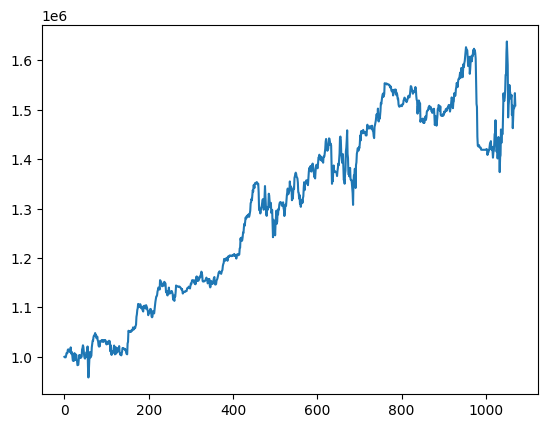

In [ ]:
%matplotlib inline
df_account_value.account_value.plot()

In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.101634
Cumulative returns     0.508892
Annual volatility      0.126291
Sharpe ratio           0.830671
Calmar ratio           0.654105
Stability              0.908377
Max drawdown          -0.155378
Omega ratio            1.179738
Sortino ratio          1.147542
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.989027
Daily value at risk   -0.015495
dtype: float64


### Данные по индексу Dow Jones

In [ ]:

print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

[*********************100%%**********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (1070, 8)
Annual return          0.097390
Cumulative returns     0.483797
Annual volatility      0.206889
Sharpe ratio           0.553897
Calmar ratio           0.262605
Stability              0.731419
Max drawdown          -0.370862
Omega ratio            1.136064
Sortino ratio          0.757662
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.837628
Daily value at risk   -0.025611
dtype: float64


### Сохраняем их

In [ ]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * koef_progi["initial_amount"]
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji+.csv")

df_account_value.to_csv('df_account_value.csv')

df_dji:              date           dji
0     2016-04-06  1.000000e+06
1     2016-04-07  9.901733e+05
2     2016-04-08  9.921489e+05
3     2016-04-11  9.909889e+05
4     2016-04-12  1.000293e+06
...          ...           ...
1066  2020-06-30  1.457034e+06
1067  2020-07-01  1.452636e+06
1068  2020-07-02  1.457851e+06
1069  2020-07-06  1.483797e+06
1070  2020-07-07           NaN

[1071 rows x 2 columns]
df_dji:                       dji
date                    
2016-04-06  1.000000e+06
2016-04-07  9.901733e+05
2016-04-08  9.921489e+05
2016-04-11  9.909889e+05
2016-04-12  1.000293e+06
...                  ...
2020-06-30  1.457034e+06
2020-07-01  1.452636e+06
2020-07-02  1.457851e+06
2020-07-06  1.483797e+06
2020-07-07           NaN

[1071 rows x 1 columns]


### Рассматриваем индекс турбуленции

In [ ]:
data_risk_indicator = obrabotanie_poln[(obrabotanie_poln.date<TRAIN_END_DATE) & (obrabotanie_poln.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [ ]:
insample_risk_indicator.vix.describe()

count    1509.000000
mean       20.743797
std         8.344143
min        10.320000
25%        14.730000
50%        17.990000
75%        24.270000
max        56.650002
Name: vix, dtype: float64

In [ ]:
koef_progi = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **koef_progi)

### Сохраняем все алгоритмы, чтобы потом отобразить на графике

In [ ]:
trained_moedl = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)



hit end!


In [ ]:
trained_moedl = trained_ddpg
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:
trained_moedl = trained_ppo
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:
trained_moedl = trained_td3
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:
trained_moedl = trained_sac
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:
df_account_value_a2c.shape

(1154, 2)

# Портфельная теория Марковица


---



In [ ]:
def process_df_for_mvo(df):
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  fst = df
  fst = fst.iloc[0:stock_dimension, :]
  tic = fst['tic'].tolist()

  mvo = pd.DataFrame()

  for k in range(len(tic)):
    mvo[tic[k]] = 0

  for i in range(df.shape[0]//stock_dimension):
    n = df
    n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()

  return mvo

In [ ]:
def StockReturnsComputing(StockPrice, Rows, Columns):
  import numpy as np
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: акции
    for i in range(Rows-1):     # i: цена за день
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

  return StockReturn

In [ ]:
train_mvo = data_split(obrabotanie_poln, TRAIN_START_DATE,TRAIN_END_DATE).reset_index()
trade_mvo = data_split(obrabotanie_poln, TEST_START_DATE,TEST_END_DATE).reset_index()


In [ ]:
StockData = process_df_for_mvo(train_mvo)
TradeData = process_df_for_mvo(trade_mvo)

TradeData.to_numpy()

array([[ 23.94691467,  59.68953705, 126.00510406, ...,  61.55722046,
         17.38575745,  53.09407806],
       [ 23.34682274,  58.77109909, 126.51629639, ...,  59.94137955,
         17.79875946,  53.54646301],
       [ 22.88993073,  57.1390686 , 124.50741577, ...,  59.02230072,
         17.97697258,  53.10092163],
       ...,
       [ 94.06803894,  90.34484863, 161.94999695, ...,  33.718853  ,
         40.94301987,  34.80610657],
       [103.9158783 ,  89.07531738, 158.        , ...,  33.77692032,
         40.71646118,  34.98068237],
       [106.53431702,  89.2853241 , 162.27000427, ...,  34.0839119 ,
         40.68499374,  35.1219902 ]])

In [ ]:
#рассчитываем возврат
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#рассчитываем средний возрат и ковариационную матрицу
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

#точность
np.set_printoptions(precision=3, suppress = True)

#печтаем
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.162 0.14  0.096 0.077 0.057 0.049 0.117 0.11  0.084 0.119 0.056 0.086
 0.054 0.089 0.059 0.044 0.088 0.068 0.079 0.105 0.061 0.043 0.069 0.078
 0.11  0.126 0.052 0.095 0.042 0.026]
Variance-Covariance matrix of returns
 [[3.091 1.768 1.211 1.66  1.311 0.985 1.787 1.147 1.663 1.048 0.967 1.257
  0.505 1.893 0.532 0.621 1.085 0.627 1.021 1.141 0.713 0.53  1.101 0.847
  0.986 1.086 0.624 0.836 0.404 0.804]
 [1.768 5.748 2.296 3.035 2.121 1.879 3.498 2.375 3.483 1.972 1.337 2.08
  0.919 4.61  0.983 1.044 2.032 1.297 1.93  1.955 1.4   1.034 2.075 1.979
  1.71  2.431 1.142 1.359 0.684 1.6  ]
 [1.211 2.296 3.015 2.133 1.461 1.373 2.368 1.678 1.881 1.314 1.043 1.347
  0.743 2.299 0.785 0.791 1.472 0.934 1.206 1.397 0.996 0.713 1.736 1.195
  1.334 1.291 0.719 1.129 0.536 1.242]
 [1.66  3.035 2.133 4.319 2.009 1.89  3.413 2.063 2.547 1.603 1.344 1.887
  0.839 3.02  0.908 0.866 1.935 1.121 1.637 1.723 1.289 0.827 2.06  1.521
  1.459 1.66  1.03  1.24  0.

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(30)])
mvo_weights

array([436240.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0., 230390.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,   8120.,      0.,
            0.,      0.,      0.,  88460., 160010.,      0.,  76780.,
            0.,      0.])

In [ ]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([17346.743,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
           0.   ,     0.   ,     0.   ,  2740.182,     0.   ,     0.   ,
           0.   ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
           0.   ,   185.547,     0.   ,     0.   ,     0.   ,     0.   ,
         989.821,  2579.858,     0.   ,  1384.74 ,     0.   ,     0.   ])

In [ ]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
# MVO_result

In [ ]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_result_a2c.rename(columns = {'account_value':'a2c'}, inplace = True)
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
df_result_ddpg.rename(columns = {'account_value':'ddpg'}, inplace = True)
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0])
df_result_td3.rename(columns = {'account_value':'td3'}, inplace = True)
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_result_ppo.rename(columns = {'account_value':'ppo'}, inplace = True)
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0])
df_result_sac.rename(columns = {'account_value':'sac'}, inplace = True)
df_account_value_a2c.to_csv("df_account_value_a2c.csv")

### Сохраняем все в одном датаесете

==============Compare to DJIA===========
df_result_ensemble.columns:  Index(['ensemble'], dtype='object')
df_trade_date:          datadate
0     2016-01-05
1     2016-01-06
2     2016-01-07
3     2016-01-08
4     2016-01-11
...          ...
1148  2020-07-28
1149  2020-07-29
1150  2020-07-30
1151  2020-07-31
1152  2020-08-03

[1153 rows x 1 columns]
df_result_ensemble:                  ensemble
date                    
2016-04-06  1.000000e+06
2016-04-07  9.990522e+05
2016-04-08  9.992779e+05
2016-04-11  9.989207e+05
2016-04-12  1.002039e+06
...                  ...
2020-06-30  1.506246e+06
2020-07-01  1.502782e+06
2020-07-02  1.505659e+06
2020-07-06  1.533535e+06
2020-07-07  1.508892e+06

[1071 rows x 1 columns]
==============Compare to DJIA===========
                       a2c            ddpg             td3             ppo  \
date                                                                         
2016-01-04  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
201

<Figure size 1500x500 with 0 Axes>

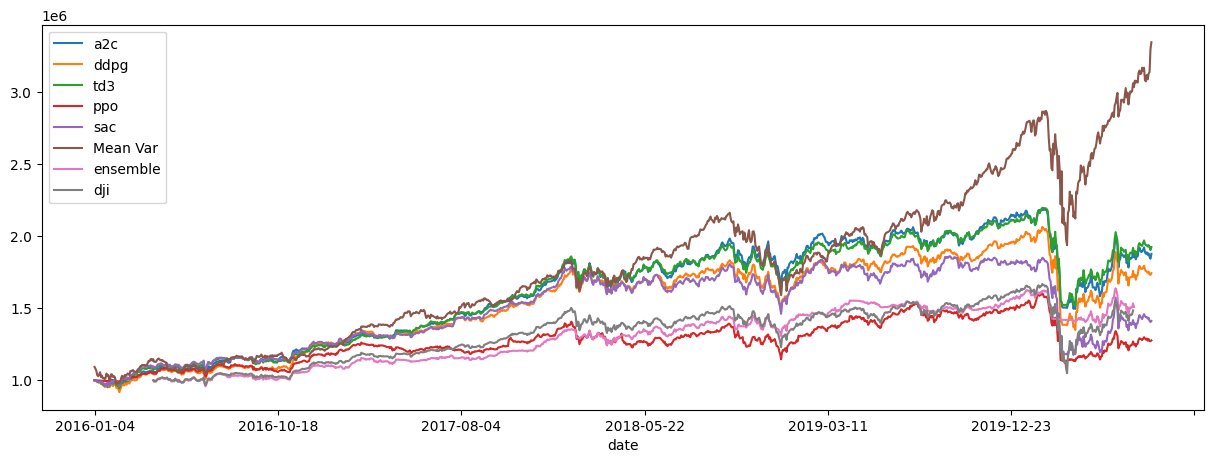

In [ ]:
print("==============Compare to DJIA===========")

df.to_csv("df.csv")
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

print("df_result_ensemble.columns: ", df_result_ensemble.columns)


print("df_trade_date: ", df_trade_date)
df_result_ensemble.to_csv("df_result_ensemble.csv")
print("df_result_ensemble: ", df_result_ensemble)
print("==============Compare to DJIA===========")
result = pd.DataFrame()


result = pd.DataFrame()
result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_td3, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_sac, how='outer', left_index=True, right_index=True)
result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_ensemble, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_dji, how='outer', left_index=True, right_index=True)

result.to_csv("result.csv")


print(result.head())


#result.columns = ['ensemble', 'dji']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();

# Сравниваем результаты

---



In [ ]:
df_dji

,dji
date,
2016-04-06,1.000000e+06
2016-04-07,9.901733e+05
2016-04-08,9.921489e+05
2016-04-11,9.909889e+05
2016-04-12,1.000293e+06
...,...
2020-06-30,1.457034e+06
2020-07-01,1.452636e+06
2020-07-02,1.457851e+06


In [ ]:
result

,ensemble,dji
date,,
2016-04-06,1.000000e+06,1.000000e+06
2016-04-07,9.990522e+05,9.901733e+05
2016-04-08,9.992779e+05,9.921489e+05
2016-04-11,9.989207e+05,9.909889e+05
2016-04-12,1.002039e+06,1.000293e+06
...,...,...
2020-06-30,1.506246e+06,1.457034e+06
2020-07-01,1.502782e+06,1.452636e+06
2020-07-02,1.505659e+06,1.457851e+06


==============Compare to DJIA===========
df_result_ensemble.columns:  Index(['ensemble'], dtype='object')
df_trade_date:          datadate
0     2016-01-05
1     2016-01-06
2     2016-01-07
3     2016-01-08
4     2016-01-11
...          ...
1148  2020-07-28
1149  2020-07-29
1150  2020-07-30
1151  2020-07-31
1152  2020-08-03

[1153 rows x 1 columns]
df_result_ensemble:                  ensemble
date                    
2016-04-06  1.000000e+06
2016-04-07  9.990522e+05
2016-04-08  9.992779e+05
2016-04-11  9.989207e+05
2016-04-12  1.002039e+06
...                  ...
2020-06-30  1.506246e+06
2020-07-01  1.502782e+06
2020-07-02  1.505659e+06
2020-07-06  1.533535e+06
2020-07-07  1.508892e+06

[1071 rows x 1 columns]
==============Compare to DJIA===========
                       a2c            ddpg             td3             ppo  \
date                                                                         
2016-01-04  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
201

<Figure size 2000x800 with 0 Axes>

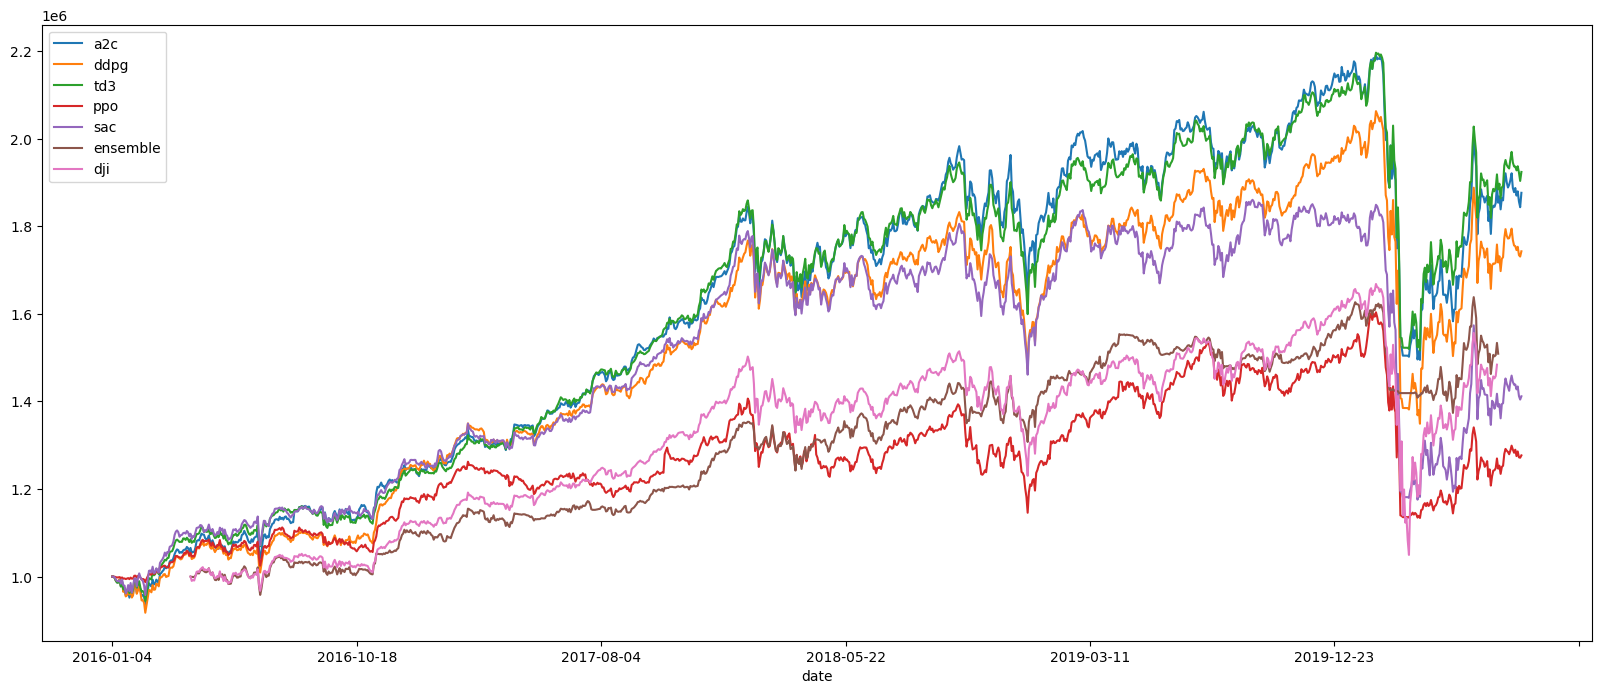

In [ ]:
print("==============Compare to DJIA===========")

df.to_csv("df.csv")
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

print("df_result_ensemble.columns: ", df_result_ensemble.columns)


print("df_trade_date: ", df_trade_date)
df_result_ensemble.to_csv("df_result_ensemble.csv")
print("df_result_ensemble: ", df_result_ensemble)
print("==============Compare to DJIA===========")
result = pd.DataFrame()


result = pd.DataFrame()
result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_td3, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_sac, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_ensemble, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_dji, how='outer', left_index=True, right_index=True)

result.to_csv("result.csv")


print(result.head())


#result.columns = ['ensemble', 'dji']

%matplotlib inline
plt.rcParams["figure.figsize"] = (20,8)
plt.figure();
result.plot();


plt.savefig('GogaRes.png')


                ensemble           dji
date                                  
2016-04-06  1.000000e+06  1.000000e+06
2016-04-07  9.990522e+05  9.901733e+05
2016-04-08  9.992779e+05  9.921489e+05
2016-04-11  9.989207e+05  9.909889e+05
2016-04-12  1.002039e+06  1.000293e+06


<Figure size 1500x500 with 0 Axes>

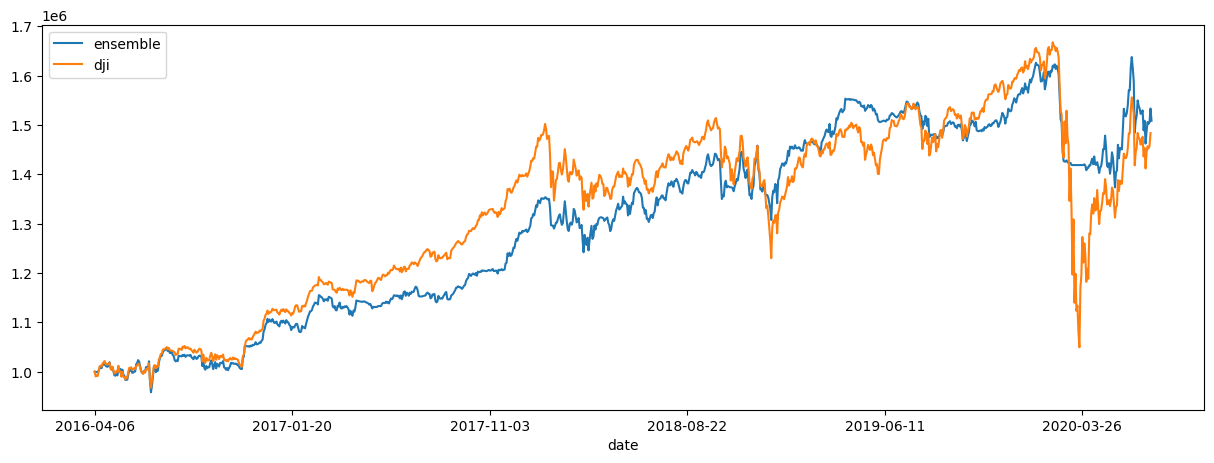

In [ ]:
result = pd.DataFrame()
result = pd.merge(result, df_result_ensemble, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_dji, how='outer', left_index=True, right_index=True)

result.to_csv("result.csv")


print(result.head())


#result.columns = ['ensemble', 'dji']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();

plt.savefig('GogaRes1.png')

<Figure size 2000x800 with 0 Axes>

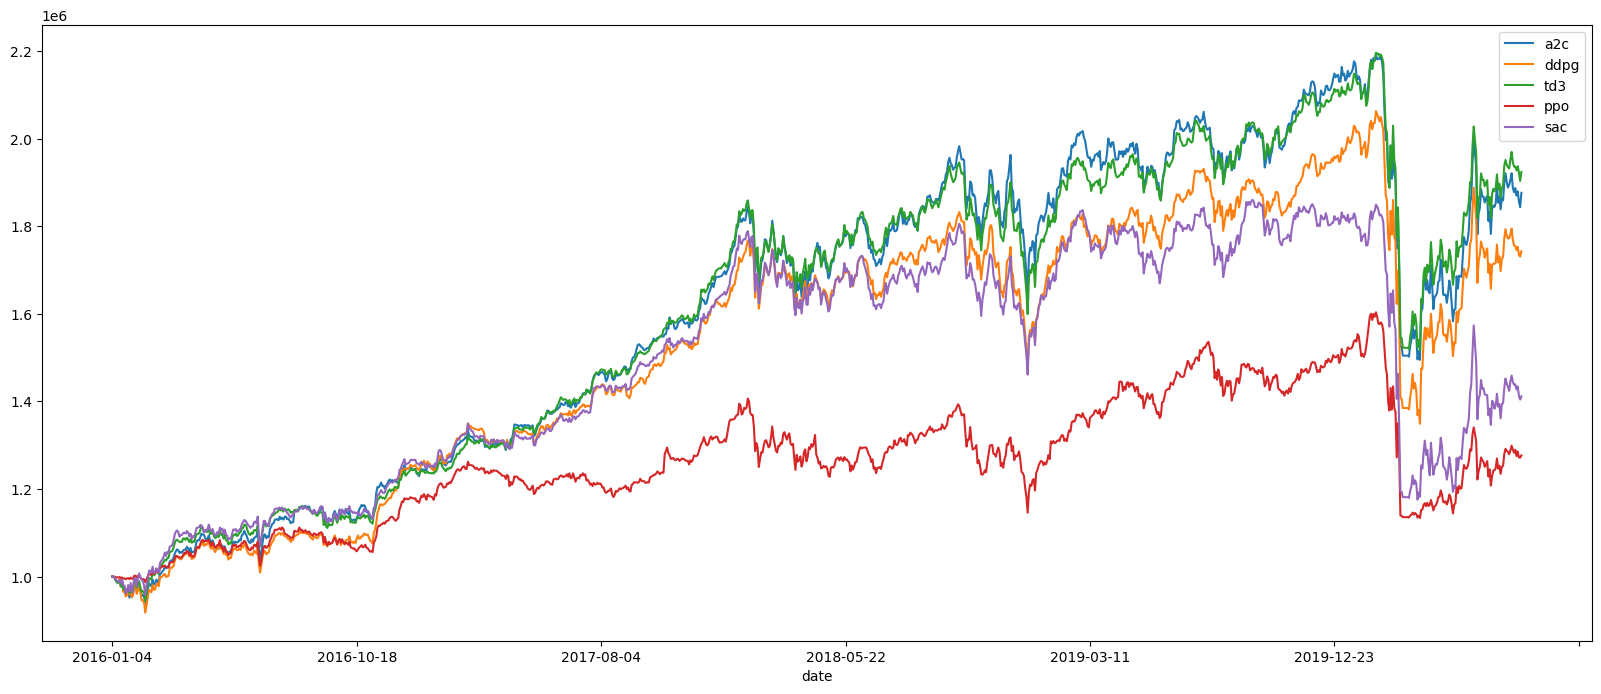

In [ ]:
result = pd.DataFrame()
result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_td3, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_sac, how='outer', left_index=True, right_index=True)

%matplotlib inline
plt.rcParams["figure.figsize"] = (20,8)
plt.figure();
result.plot();

plt.savefig('GogaRes2.png')

<Figure size 1500x500 with 0 Axes>

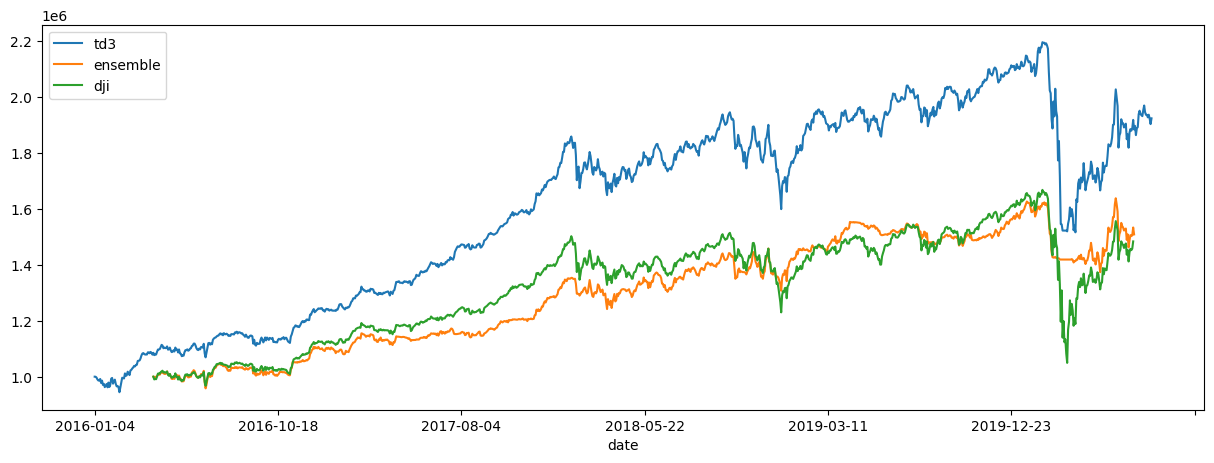

In [ ]:
result = pd.DataFrame()
result = pd.merge(result, df_result_td3, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_ensemble, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_dji, how='outer', left_index=True, right_index=True)

result.to_csv("result.csv")



#result.columns = ['ensemble', 'dji']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();


plt.savefig('GogaRes4.png')

<Figure size 1500x500 with 0 Axes>

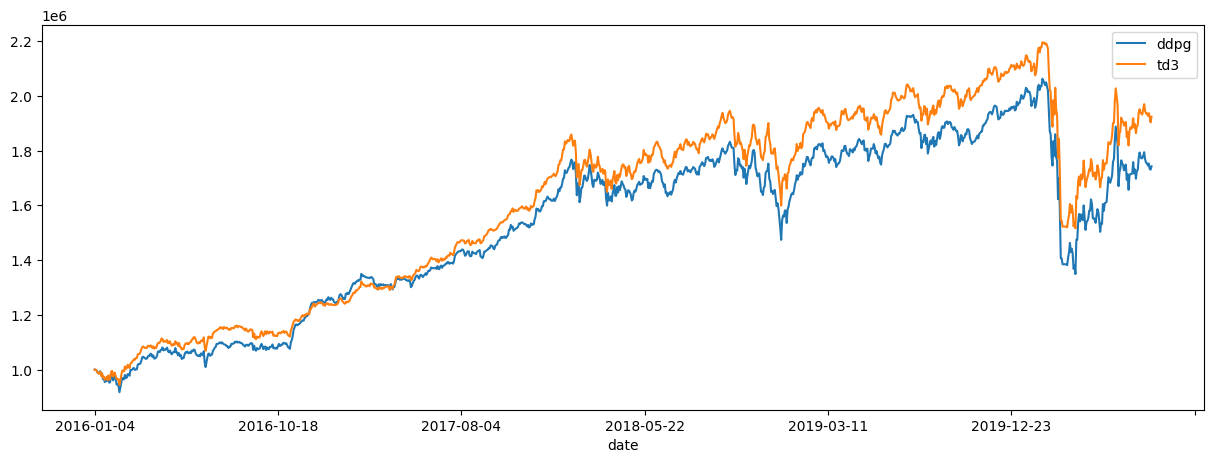

In [ ]:
result = pd.DataFrame()
result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_td3, how='outer', left_index=True, right_index=True)

result.to_csv("result.csv")



#result.columns = ['ensemble', 'dji']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();


plt.savefig('GogaRes5.png')